In [1]:
from IPython.display import display, HTML
import pandas as pd
from os import listdir
from os.path import isfile, join
from pprint import pprint
from tqdm import tqdm
import json
import io

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.font_manager import FontProperties
import numpy as np
from scipy.spatial.distance import euclidean, pdist, squareform, cosine

import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


sns.set(style="ticks")
plt.rcParams['axes.facecolor']='white'
task_order = ['Length',  'WordContent', 'Depth', 'TopConstituents', 'BigramShift', 'Tense', 'SubjNumber', 'ObjNumber', 'OddManOut', 'CoordinationInversion']
dict_task = {0:'Length',  1:'WordContent', 2:'Depth', 3:'TopConstituents', 4:'BigramShift', 5:'Tense', 6:'SubjNumber', 7:'ObjNumber', 8:'OddManOut', 9:'CoordinationInversion'}

In [2]:
def get_results(dir_path='./mlp_results'):
    columns = ['data_path', 'cache_path', 'result_path', 'batch_size', 'cbatch_size', 'nhid', 'optim', 'kfold', 'tenacity', 'usepytorch', 'epoch_size', 'device']
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        with open(join(dir_path, filename), 'r') as infile:
#             print(filename)
            results = json.load(infile)
            for key, result in results.items():
                list_result.append(result)
                
    df = pd.DataFrame(list_result)[['acc', 'head', 'layer', 'task', 'model_name']]
    
    for column in columns:
        try:
            df = df.drop(columns=column)
        except:
            pass

    return df

# Layer-Task Peformance Chart

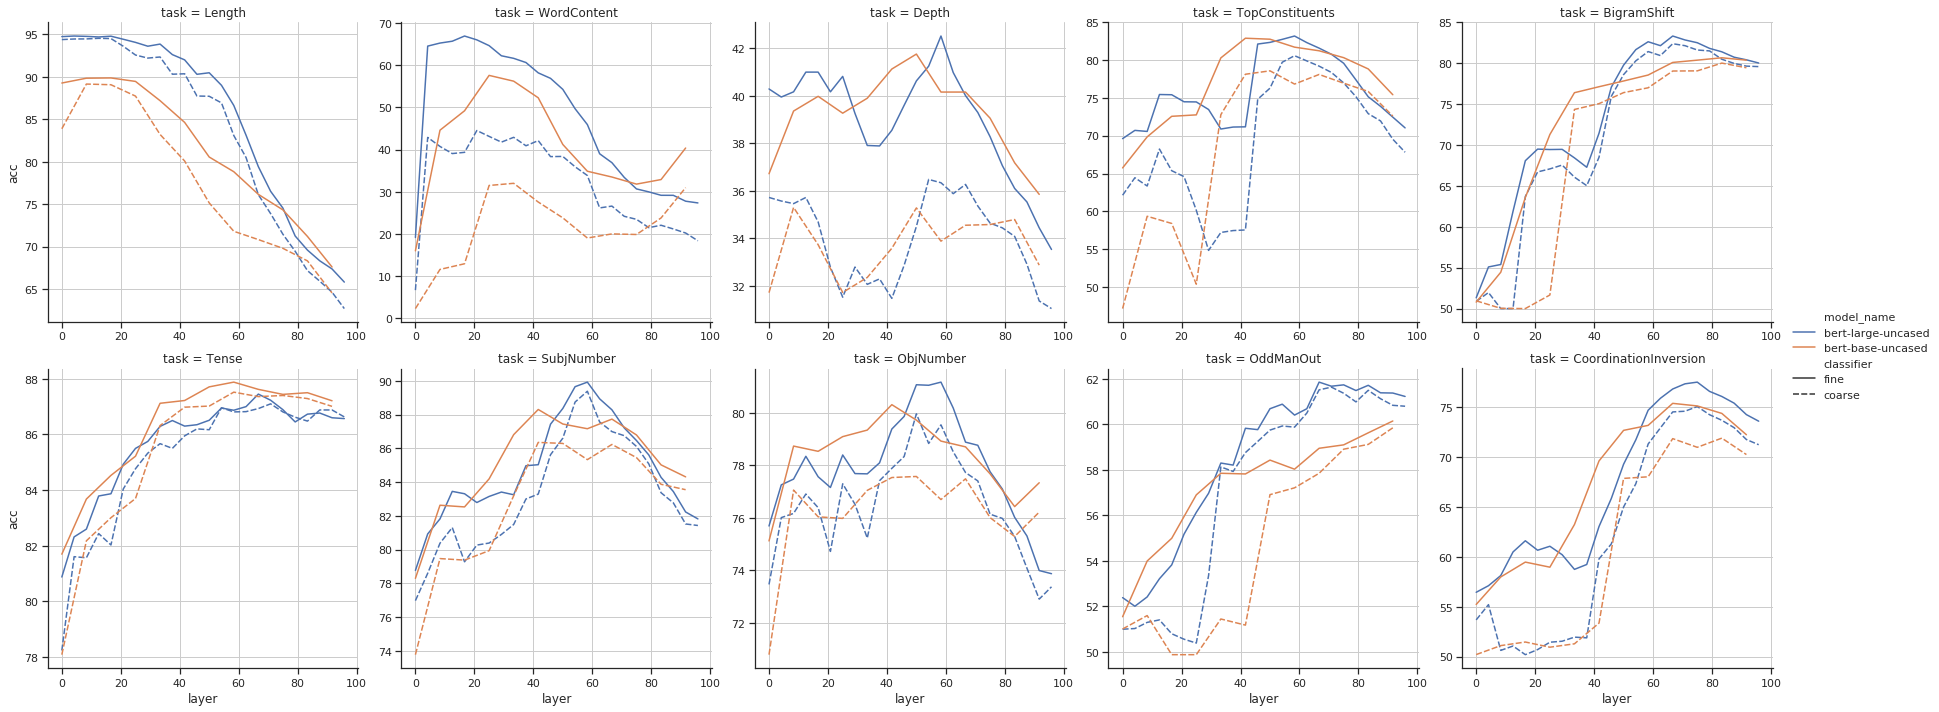

In [3]:
df1 = get_results(dir_path='./fine_mlp_results')
df1['classifier'] = 'fine'
df2 = get_results(dir_path='./mlp_results')
df2['classifier'] = 'coarse'
df1 = df1.append(df2)

df1 = df1.loc[df1['head'] == -1]
df1.loc[df1['model_name'] == 'bert-base-uncased', 'layer'] *= 100 / 12
df1.loc[df1['model_name'] == 'bert-large-uncased', 'layer'] *= 100 / 24


# df = df.loc[df['model_name'] == 'bert-base-uncased']
g = sns.relplot(x='layer', y="acc", col='task', col_wrap=5, style='classifier', col_order=task_order, hue='model_name', kind="line", legend="full", data=df1, facet_kws={'sharey':False, 'sharex':False}) #col_wrap=3
for ax in g.axes.flatten():
    ax.grid(True)
#     ax.set_ylim(0, 100)

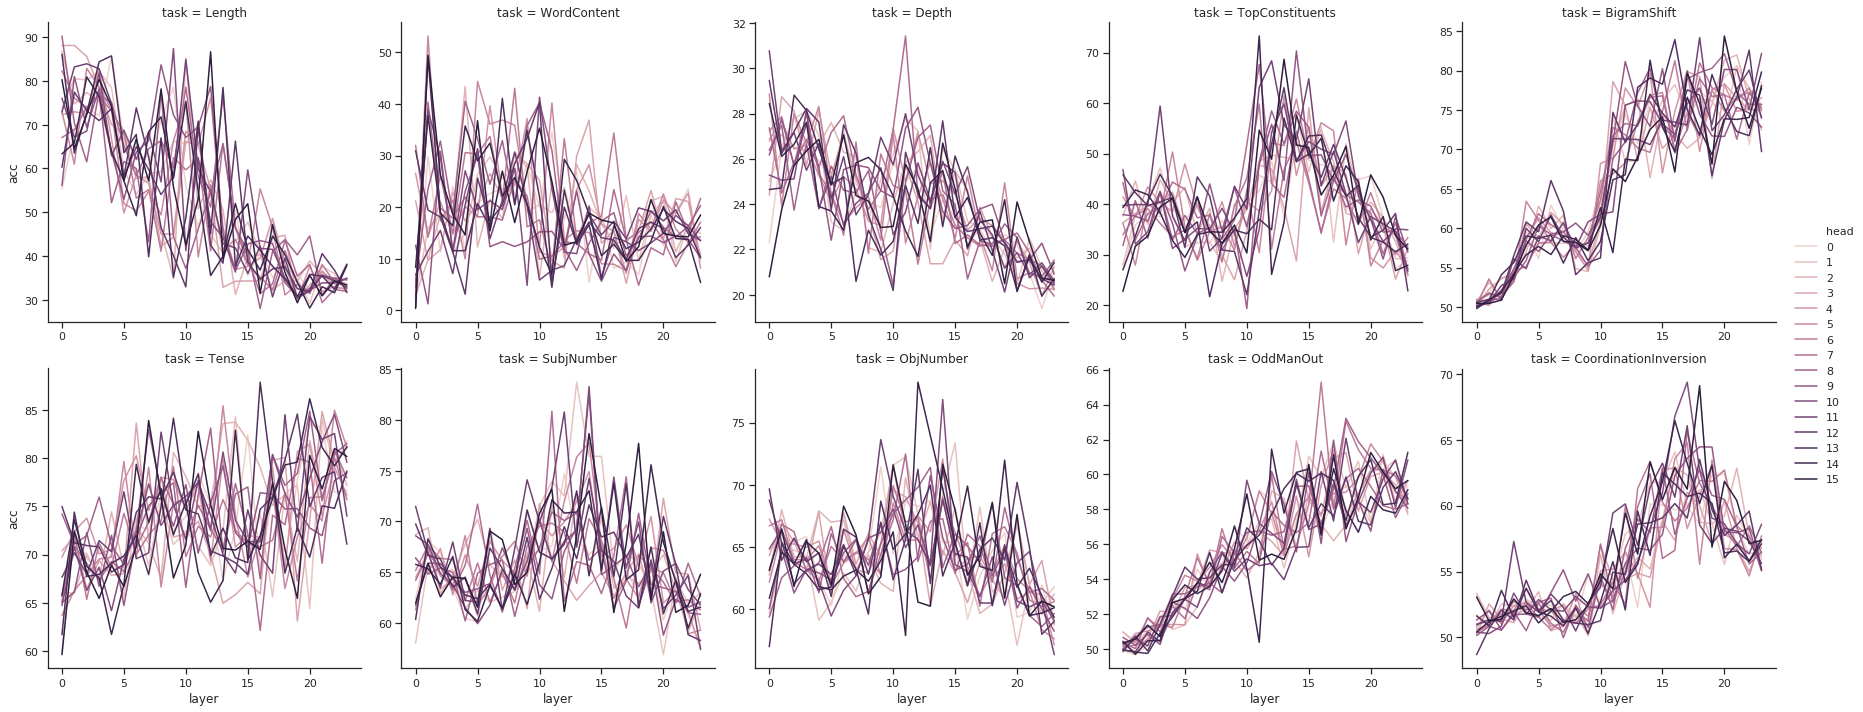

In [4]:
df = get_results(dir_path='./linear_head_wise_results')
large_bert = df.loc[df['model_name'] == 'bert-large-uncased']
# large_bert = large_bert.loc[large_bert['head'] == 2]
large_bert = large_bert[['acc', 'head', 'layer', 'task', 'model_name']]
# display(large_bert)
# large_bert = large_bert.pivot(index='layer', columns='task', values=['acc'])
g = sns.relplot(x='layer', y="acc", col='task', col_wrap=5, col_order=task_order, hue='head', kind="line", legend="full", data=large_bert, facet_kws={'sharey':False, 'sharex':False}) #col_wrap=3


# Layer-Task Performance Table

In [5]:
df = get_results(dir_path='./linear_head_wise_results')
large_bert = df.loc[df['model_name'] == 'bert-base-uncased']
large_bert = large_bert.loc[large_bert['head'] == 2]
large_bert = large_bert.pivot(index='layer', columns='task', values=['acc'])


large_bert.columns = large_bert.columns.droplevel()
large_bert = large_bert[['Length',  'WordContent', 'Depth', 'TopConstituents', 'BigramShift', 'Tense', 'SubjNumber', 'ObjNumber', 'OddManOut', 'CoordinationInversion']]
large_bert

task   Length  WordContent  Depth  TopConstituents  BigramShift  Tense  \
layer                                                                    
0       73.53         6.21  27.63            45.25        50.19  64.33   
1       63.05        10.08  25.68            38.52        50.75  71.22   
2       63.40        21.71  27.11            40.71        54.45  75.10   
3       47.12        49.45  23.70            33.02        64.10  81.73   
4       51.51        33.80  24.19            39.17        69.15  86.36   
5       48.67         9.96  24.71            50.44        69.45  78.42   
6       65.93        10.23  24.01            58.07        69.20  75.94   
7       37.79        11.21  23.60            65.63        71.47  74.86   
8       37.52         5.69  22.02            61.13        71.96  77.55   
9       39.08        13.44  23.59            49.17        74.38  86.65   
10      35.32        18.33  24.04            43.10        71.14  80.03   
11      37.39        22.72  24.21            44.63        74.12  83.65   

task   SubjNumber  ObjNumber  OddManOut  CoordinationInversion  
layer                                                           
0           71.28      67.69      50.66                  49.30  
1           66.34      68.26      51.28                  51.55  
2           65.23      64.28      53.34                  51.97  
3           65.50      65.79      55.56                  51.10  
4           66.97      65.30      55.22                  52.18  
5           68.74      65.03      54.08                  55.51  
6           66.59      64.01      52.81                  58.83  
7           74.06      64.05      55.90                  56.77  
8           67.60      61.73      55.81                  58.43  
9           74.04      62.84      55.60                  59.37  
10          69.56      66.52      56.75                  56.99  
11          71.11      66.75      57.33                  57.29

## Layer-wise Downstream Task Performance

In [6]:
df = get_results(dir_path='./downstream_results')
df['pearson'] = df['pearson'] * 100
# df = df.loc[df['task'] != 'SICKEntailment']
# df = df.loc[df['task'] == 'STS12']

# df = df.loc['task']
g = sns.relplot(x='layer', y="pearson", row='task', hue='head', kind="line", legend="full", data=df, facet_kws={'sharey':False, 'sharex':False}) #col_wrap=3
for ax in g.axes.flatten():
    ax.grid(True)
#     ax.set_ylim(0, 100)
    ax.set_title('')



KeyError: 'pearson'

# Head Wise Data Inspection

acc                                                                 \
head      0      1      2      3      4      5      6      7      8      9    
layer                                                                         
0      18.33   0.89   6.21  12.03  27.85   0.95   0.63   4.47   9.90  14.17   
1      32.92  21.00  10.08  12.61  13.11  20.50   0.60   2.41  33.83  41.78   
2       1.91   6.99  21.71  18.10   9.71  29.86  25.76   6.66   9.15   1.50   
3       1.95   6.76  49.45   3.09  42.06   3.03  50.31   8.05   4.87   3.18   
4       8.34  45.35  33.80   6.51  11.98   3.78  10.76   6.45   7.22  22.19   
5       9.83   5.85   9.96  21.81  18.91   6.67   3.35  16.40  25.47   8.22   
6      14.10  15.85  10.23   1.35  25.51  25.25   7.95  24.76   9.93   5.42   
7      13.93  14.82  11.21   7.67   2.06  23.70  11.04  10.77  11.23   8.73   
8      16.92  22.09   5.69  12.89  13.80   8.81   2.82  22.22  17.76  16.27   
9      19.44  10.29  13.44  14.39  10.30  10.14   5.12  20.75  14.00   5.94   
10     21.15  20.16  18.33  25.32  17.31  12.50  22.14  23.97  14.12  13.63   
11     23.23  24.69  22.72  21.40  27.37  36.55  26.20  23.27  22.20  29.27   

                     
head      10     11  
layer                
0       7.99   1.37  
1      16.16  20.00  
2      15.23   8.38  
3       3.92   2.81  
4       2.09  13.77  
5      13.44   6.53  
6      19.20   8.26  
7      17.22  10.68  
8       6.39  12.36  
9      19.43  19.94  
10     14.78  20.44  
11     21.64  31.49

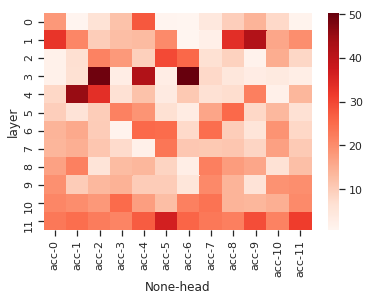

In [7]:
df = get_results(dir_path='./linear_head_wise_results')
df = df.loc[df['model_name'] == 'bert-base-uncased']
df = df.loc[df['head'] >= 0]
df = df.loc[df['task'] == dict_task[1]] # Choose task
df = df.pivot(index='layer', columns='head', values=['acc'])
display(df)
sns.heatmap(df, cmap='Reds')

# Head Wise Sorted Data Inspection  

위 heatmap을 통해서는 정확하게 얼마나 분포하고 있는지 알기가 힘들기 때문에 sorted 시켜보았다.

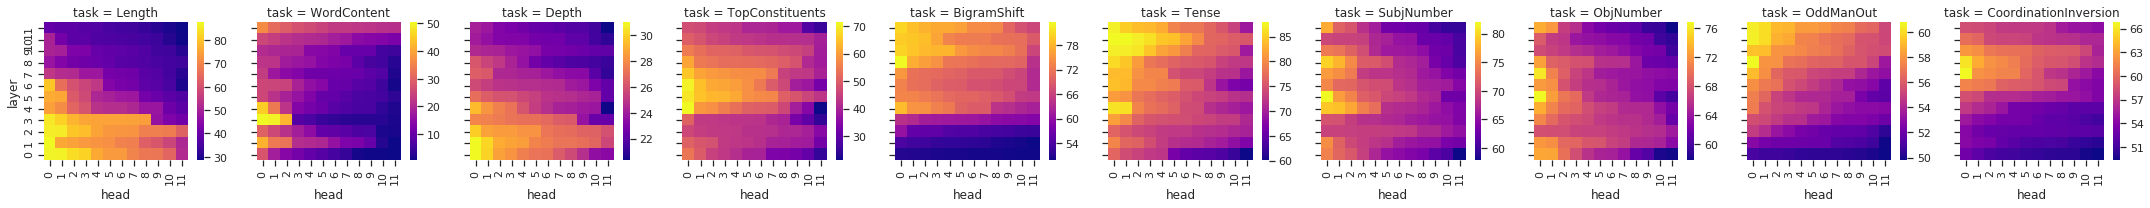

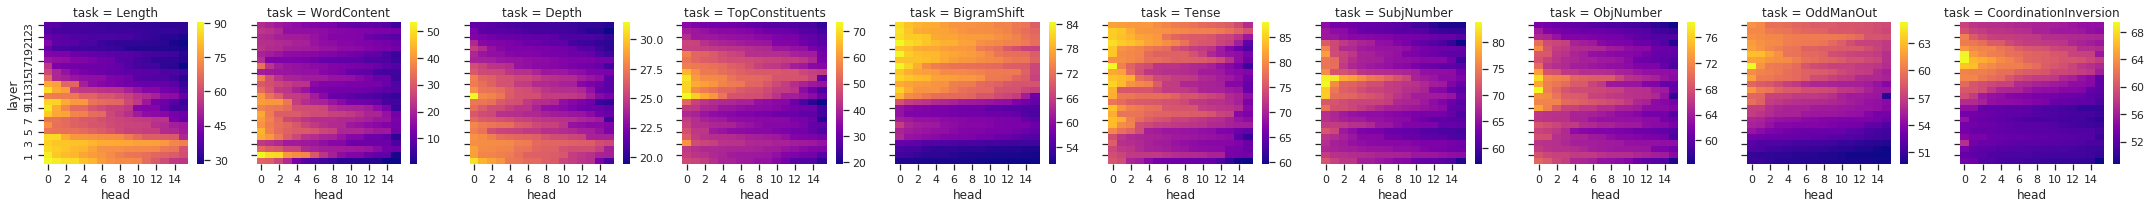

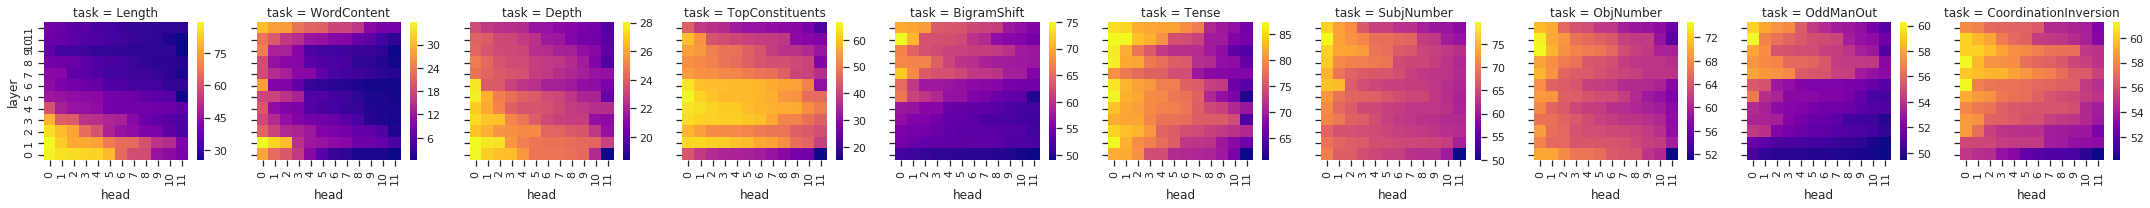

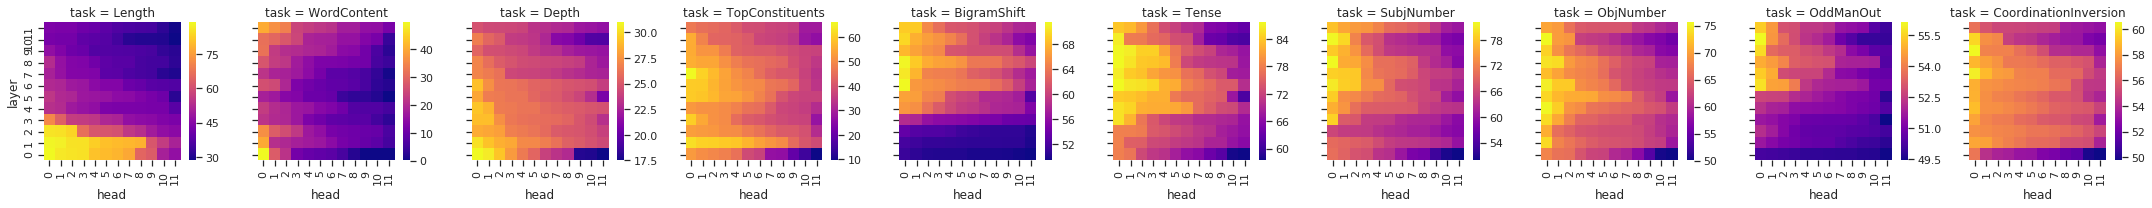

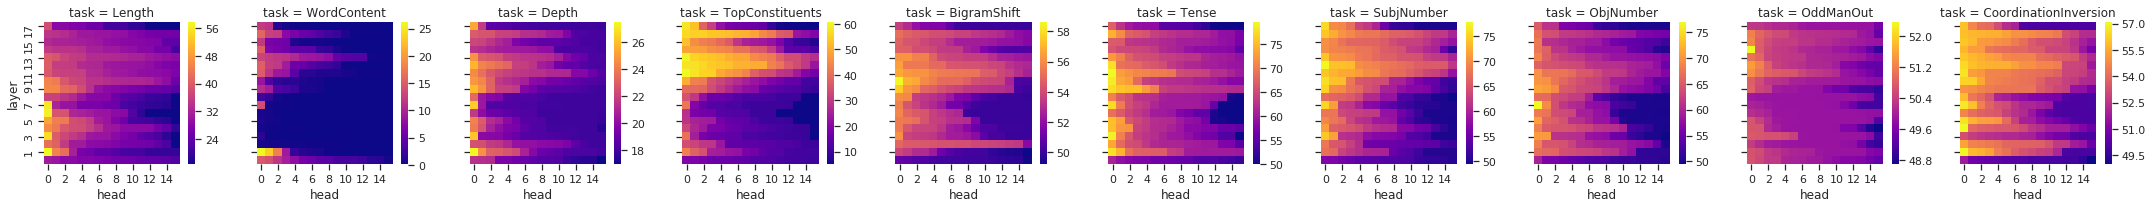

In [8]:
plt_cmap = 'plasma'# 'viridis'

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    data = d.values
    data.sort(axis=1)
    d.iloc[:,:] = np.flip(data, 1)
    sns.heatmap(d[::-1], **kwargs)

df = get_results(dir_path='./linear_head_wise_results')
df = df.loc[df['model_name'] == 'bert-base-uncased']
df = df.loc[df['head'] >= 0]
fg = sns.FacetGrid(df, col='task', col_wrap=10, col_order=task_order)
fg.map_dataframe(draw_heatmap, 'head', 'layer', 'acc', cbar=True, square = False, cmap=plt_cmap)

df = get_results(dir_path='./linear_head_wise_results')
df = df.loc[df['model_name'] == 'bert-large-uncased']
df = df.loc[df['head'] >= 0]
fg = sns.FacetGrid(df, col='task', col_wrap=10, col_order=task_order)
fg.map_dataframe(draw_heatmap, 'head', 'layer', 'acc', cbar=True, square = False, cmap=plt_cmap)

df = get_results(dir_path='./linear_head_wise_results')
df = df.loc[df['model_name'] == 'openai-gpt']
df = df.loc[df['head'] >= 0]
fg = sns.FacetGrid(df, col='task', col_wrap=10, col_order=task_order)
fg.map_dataframe(draw_heatmap, 'head', 'layer', 'acc', cbar=True, square = False, cmap=plt_cmap)

df = get_results(dir_path='./linear_head_wise_results')
df = df.loc[df['model_name'] == 'gpt2']
df = df.loc[df['head'] >= 0]
fg = sns.FacetGrid(df, col='task', col_wrap=10, col_order=task_order)
fg.map_dataframe(draw_heatmap, 'head', 'layer', 'acc', cbar=True, square = False, cmap=plt_cmap)

df = get_results(dir_path='./linear_head_wise_results')
df = df.loc[df['model_name'] == 'transfo-xl-wt103']
df = df.loc[df['head'] >= 0]
fg = sns.FacetGrid(df, col='task', col_wrap=10, col_order=task_order)
fg.map_dataframe(draw_heatmap, 'head', 'layer', 'acc', cbar=True, square = False, cmap=plt_cmap)

# Head-Wise Task Pair-plot

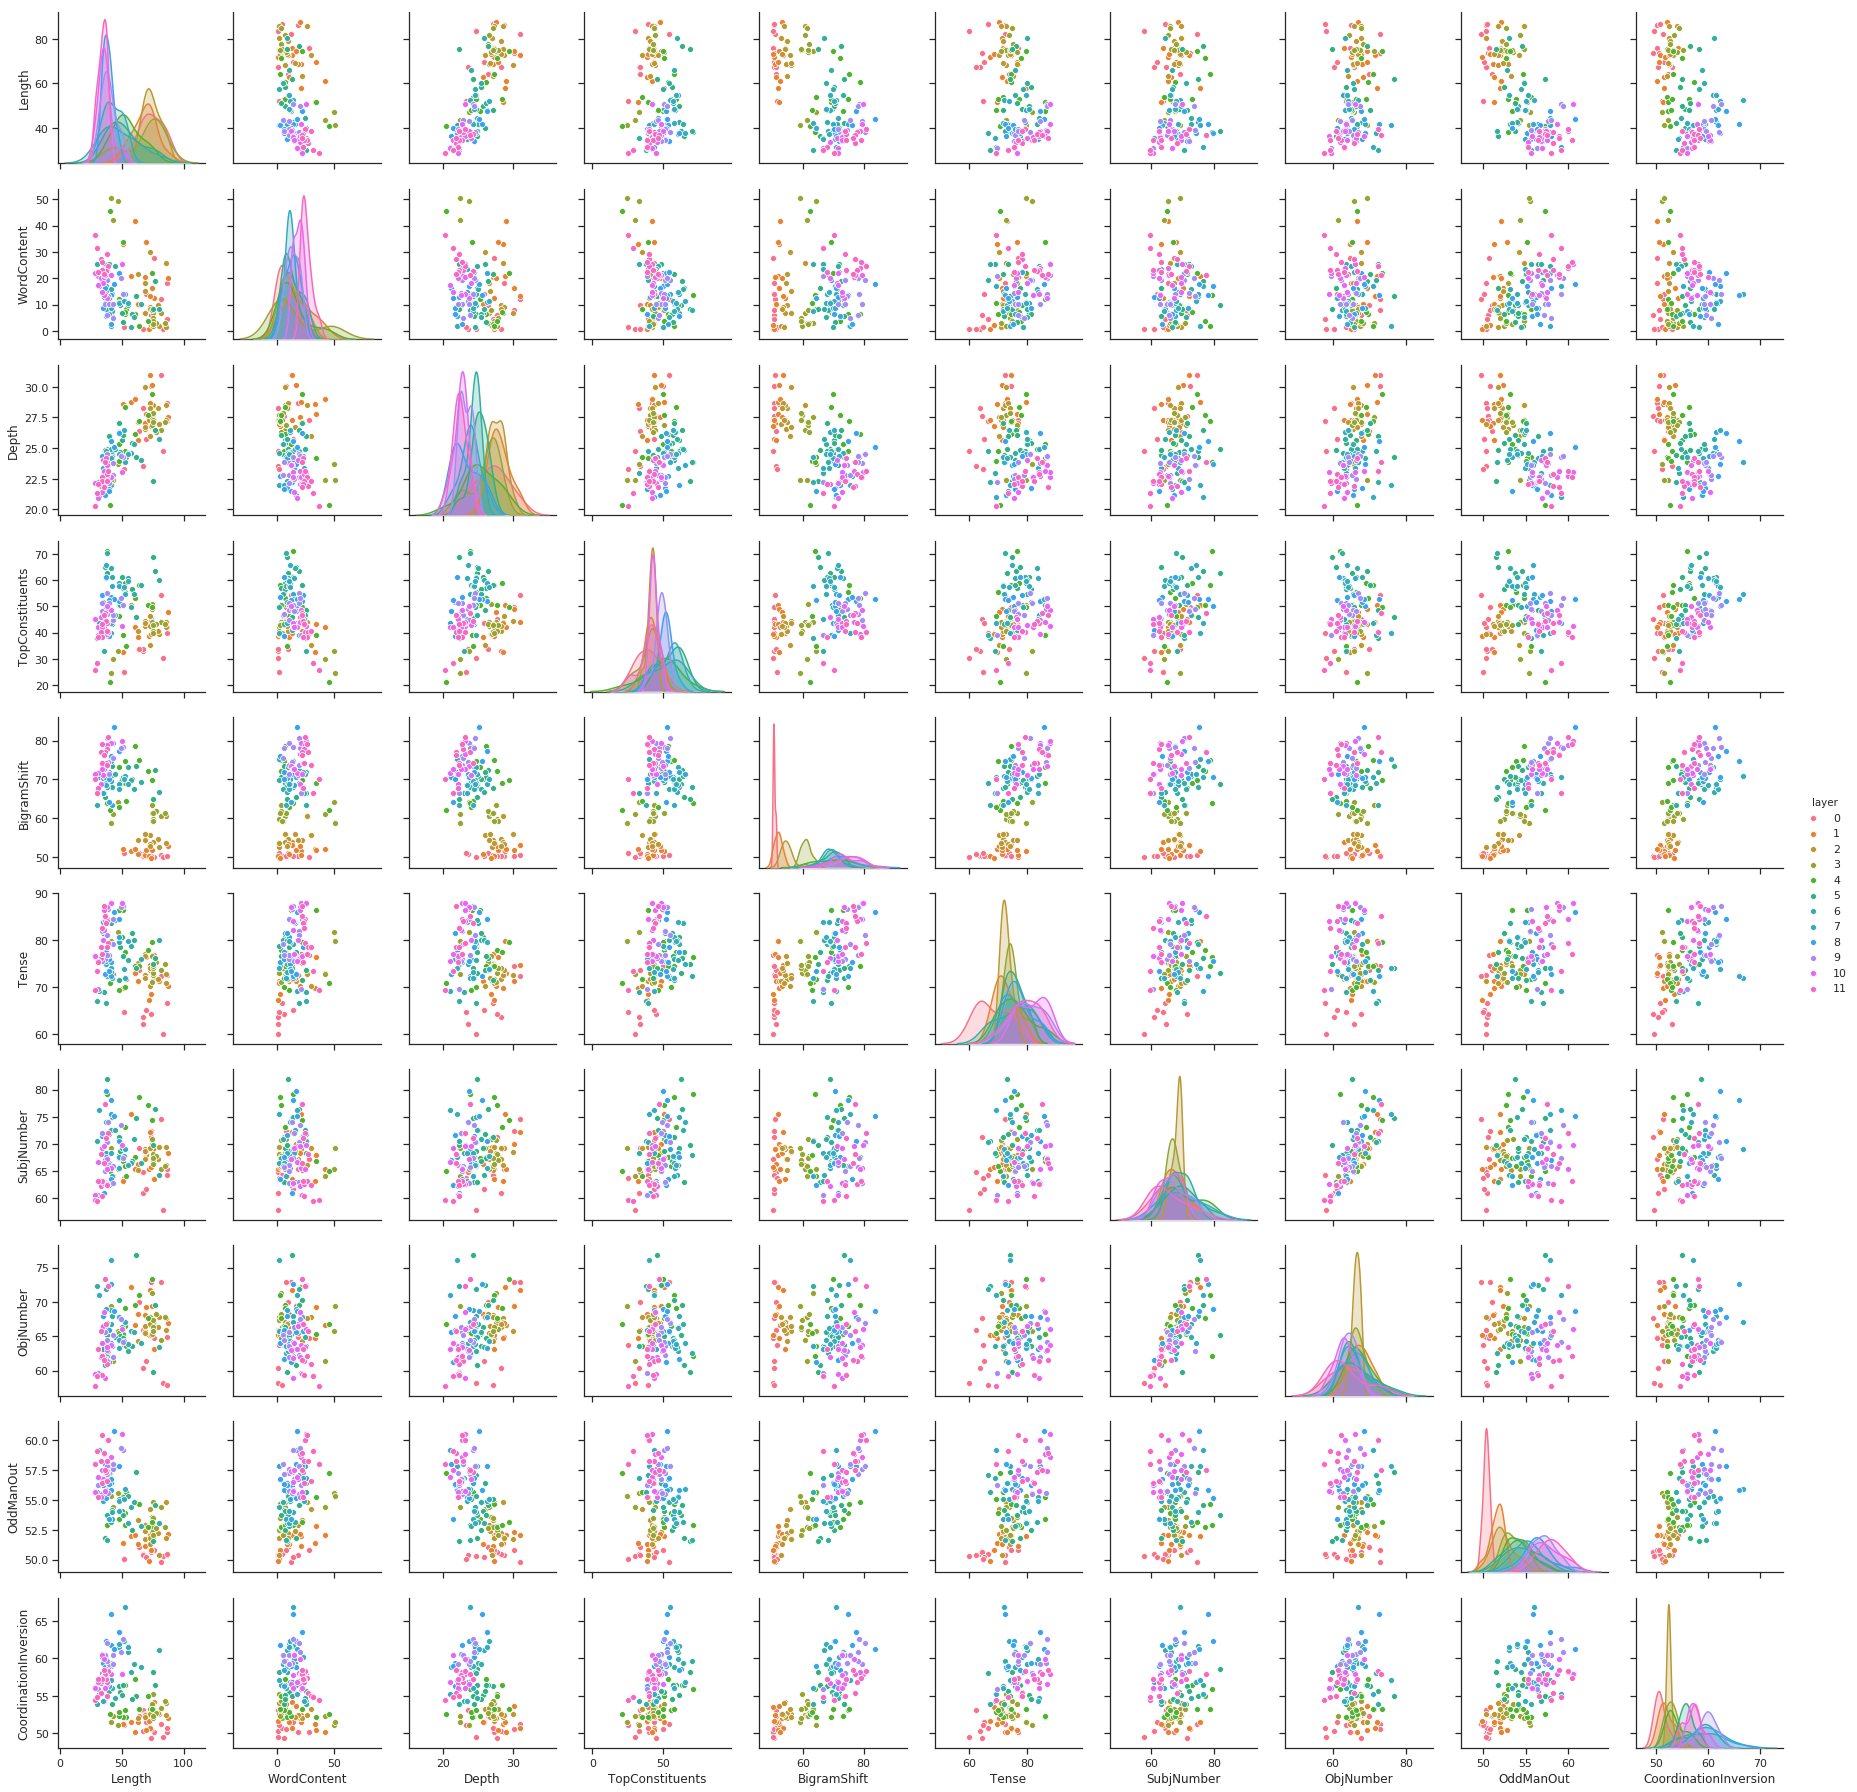

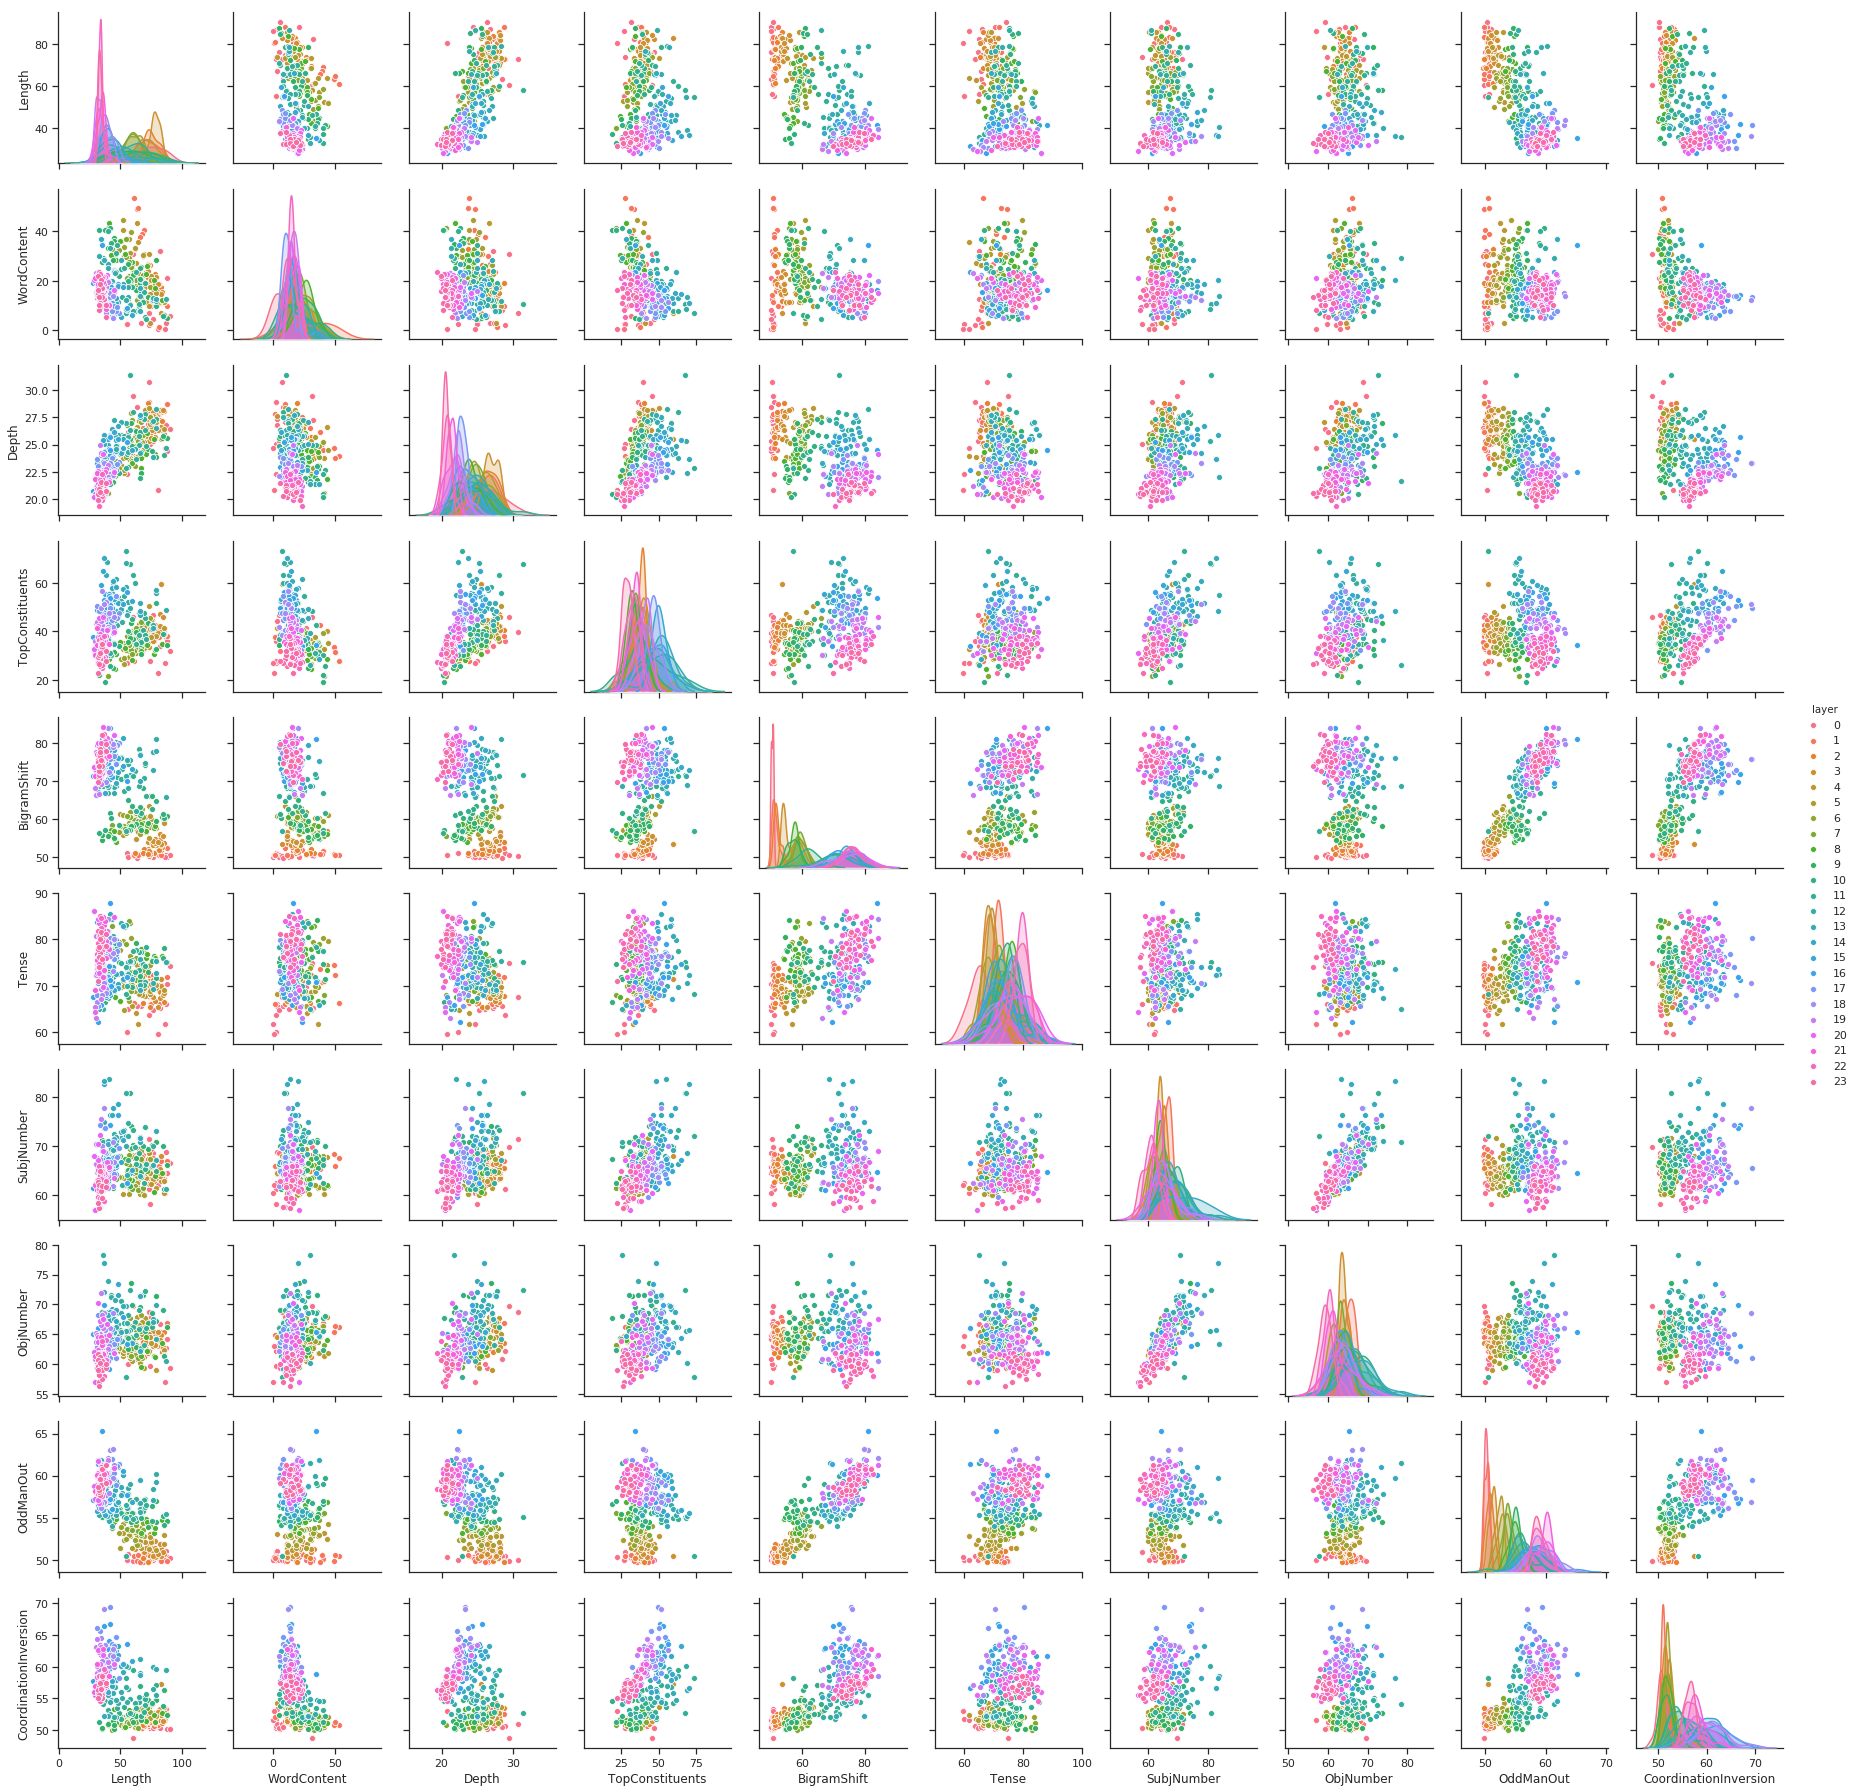

In [9]:
df = get_results(dir_path='./linear_head_wise_results')
df = df.loc[df['model_name'] == 'bert-base-uncased']
df = df.loc[df['head'] >= 0]
df = df.pivot_table(index=['layer', 'head'], columns='task', values='acc')
df = df.reset_index()
sns.pairplot(df, hue='layer', vars=['Length',  'WordContent', 'Depth', 'TopConstituents', 'BigramShift', 'Tense', 'SubjNumber', 'ObjNumber', 'OddManOut', 'CoordinationInversion'])

df = get_results(dir_path='./linear_head_wise_results')
df = df.loc[df['model_name'] == 'bert-large-uncased']
df = df.loc[df['head'] >= 0]
df = df.pivot_table(index=['layer', 'head'], columns='task', values='acc')
df = df.reset_index()
sns.pairplot(df, hue='layer', vars=['Length',  'WordContent', 'Depth', 'TopConstituents', 'BigramShift', 'Tense', 'SubjNumber', 'ObjNumber', 'OddManOut', 'CoordinationInversion'])

# Task-Wise Clustering

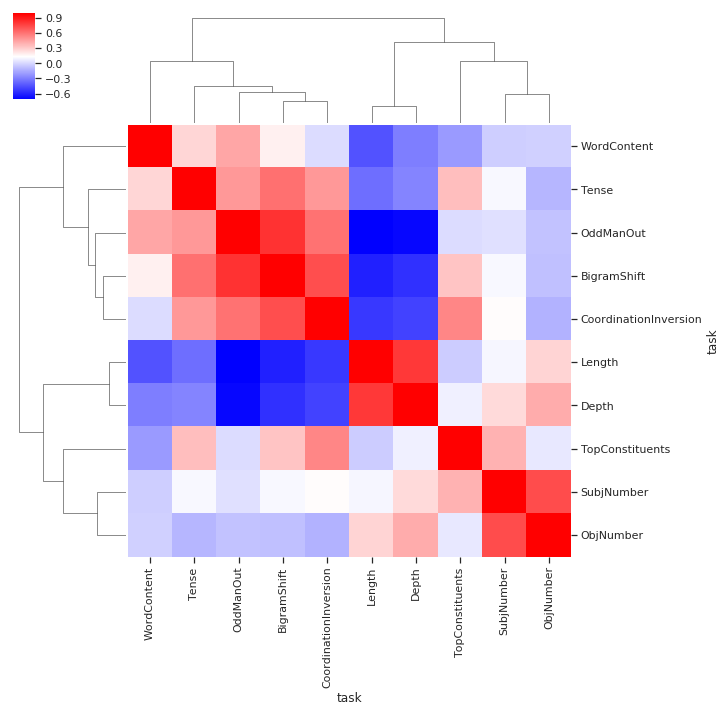

In [10]:
df = get_results(dir_path='./linear_head_wise_results')
df = df.loc[df['model_name'] == 'bert-base-uncased']
df = df.loc[df['head'] >= 0]

df = df.pivot_table(index=['layer', 'head'], columns='task', values='acc')
df = df.reset_index().drop(columns=['head', 'layer'])
df = df[task_order]

df = df.corr(method='spearman')

# sns.heatmap(df, annot=True, cmap='bwr', center=0)
sns.clustermap(df, cmap='bwr')

# Head-wise Similarity Analysis

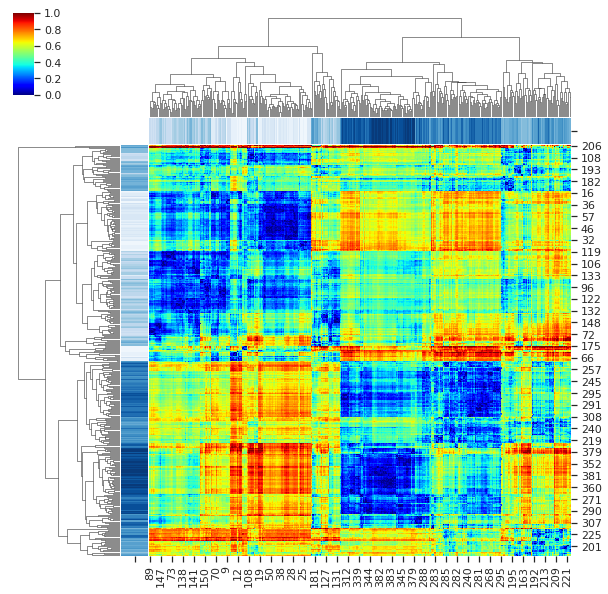

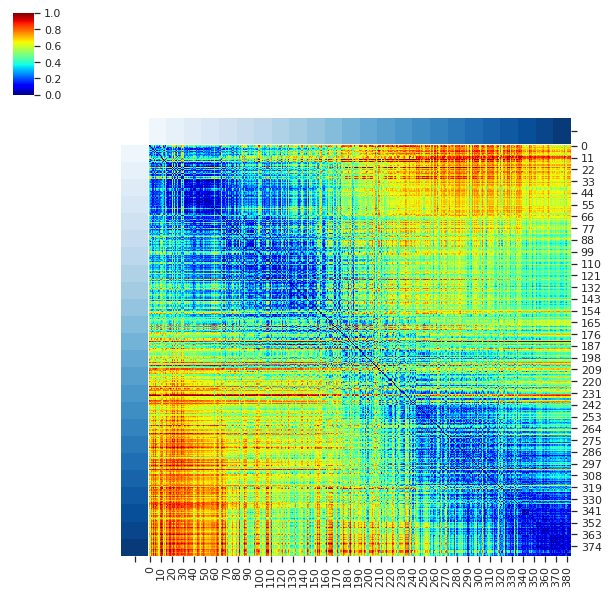

In [11]:
from scipy.cluster.hierarchy import linkage

df = get_results(dir_path='./linear_head_wise_results')
df = df.loc[df['model_name'] == 'bert-large-uncased']
df = df.loc[df['head'] >= 0]
df = df.pivot_table(index=['layer', 'head'], columns='task', values='acc')
df_layer = df.index.get_level_values('layer')
lut = dict(zip(df_layer.unique(), sns.color_palette("Blues", len(df_layer.unique()))))
col_colors = pd.Series(df_layer.values).map(lut)


df = df.reset_index().drop(columns=['head', 'layer'])
df = df[task_order]

# ====== Column-wise Normalization ===== #
df=(df-df.mean())/df.std() # std norm
# df=(df-df.min())/(df.max()-df.min())

Z = linkage(df.values, metric='euclidean')
df = df.T.corr(method=euclidean)
# display(df)
g = sns.clustermap(df, cmap='jet', metric='euclidean', standard_scale=1, row_cluster=True, col_cluster=True, col_colors=col_colors, row_colors=col_colors)
col_idx = g.dendrogram_col.reordered_ind
# sns.heatmap(df, cmap='bwr', center=0)

g = sns.clustermap(df, cmap='jet', metric='euclidean', standard_scale=1, row_cluster=False, col_cluster=False, col_colors=col_colors, row_colors=col_colors, row_linkage=Z, col_linkage=Z)



# Head-wise Dimensionality Reduction

No handles with labels found to put in legend.


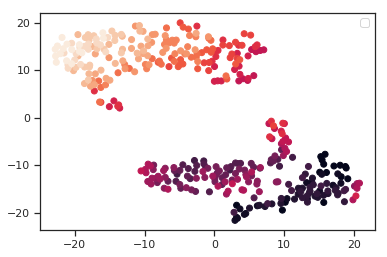

In [12]:
df = get_results(dir_path='./linear_head_wise_results')
df = df.loc[df['model_name'] == 'bert-large-uncased']
df = df.pivot_table(index=['layer', 'head'], columns='task', values='acc')

df = df.reset_index()
df = df.loc[df['head'] >= 0]
layer = df['layer']
df = df.drop(columns=['head', 'layer'])

# ====== Column-wise Normalization ===== #
# df=(df-df.mean())/df.std() # std norm
# df=(df-df.min())/(df.max()-df.min())
# display(df)


# print(layer.values.shape)
X = df.values


X_embedded = TSNE(n_components=2).fit_transform(X)
# X_embedded = PCA(n_components=2).fit_transform(X)
# print(X_embedded.shape)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=layer.values)
plt.legend()

# Average Head Feature

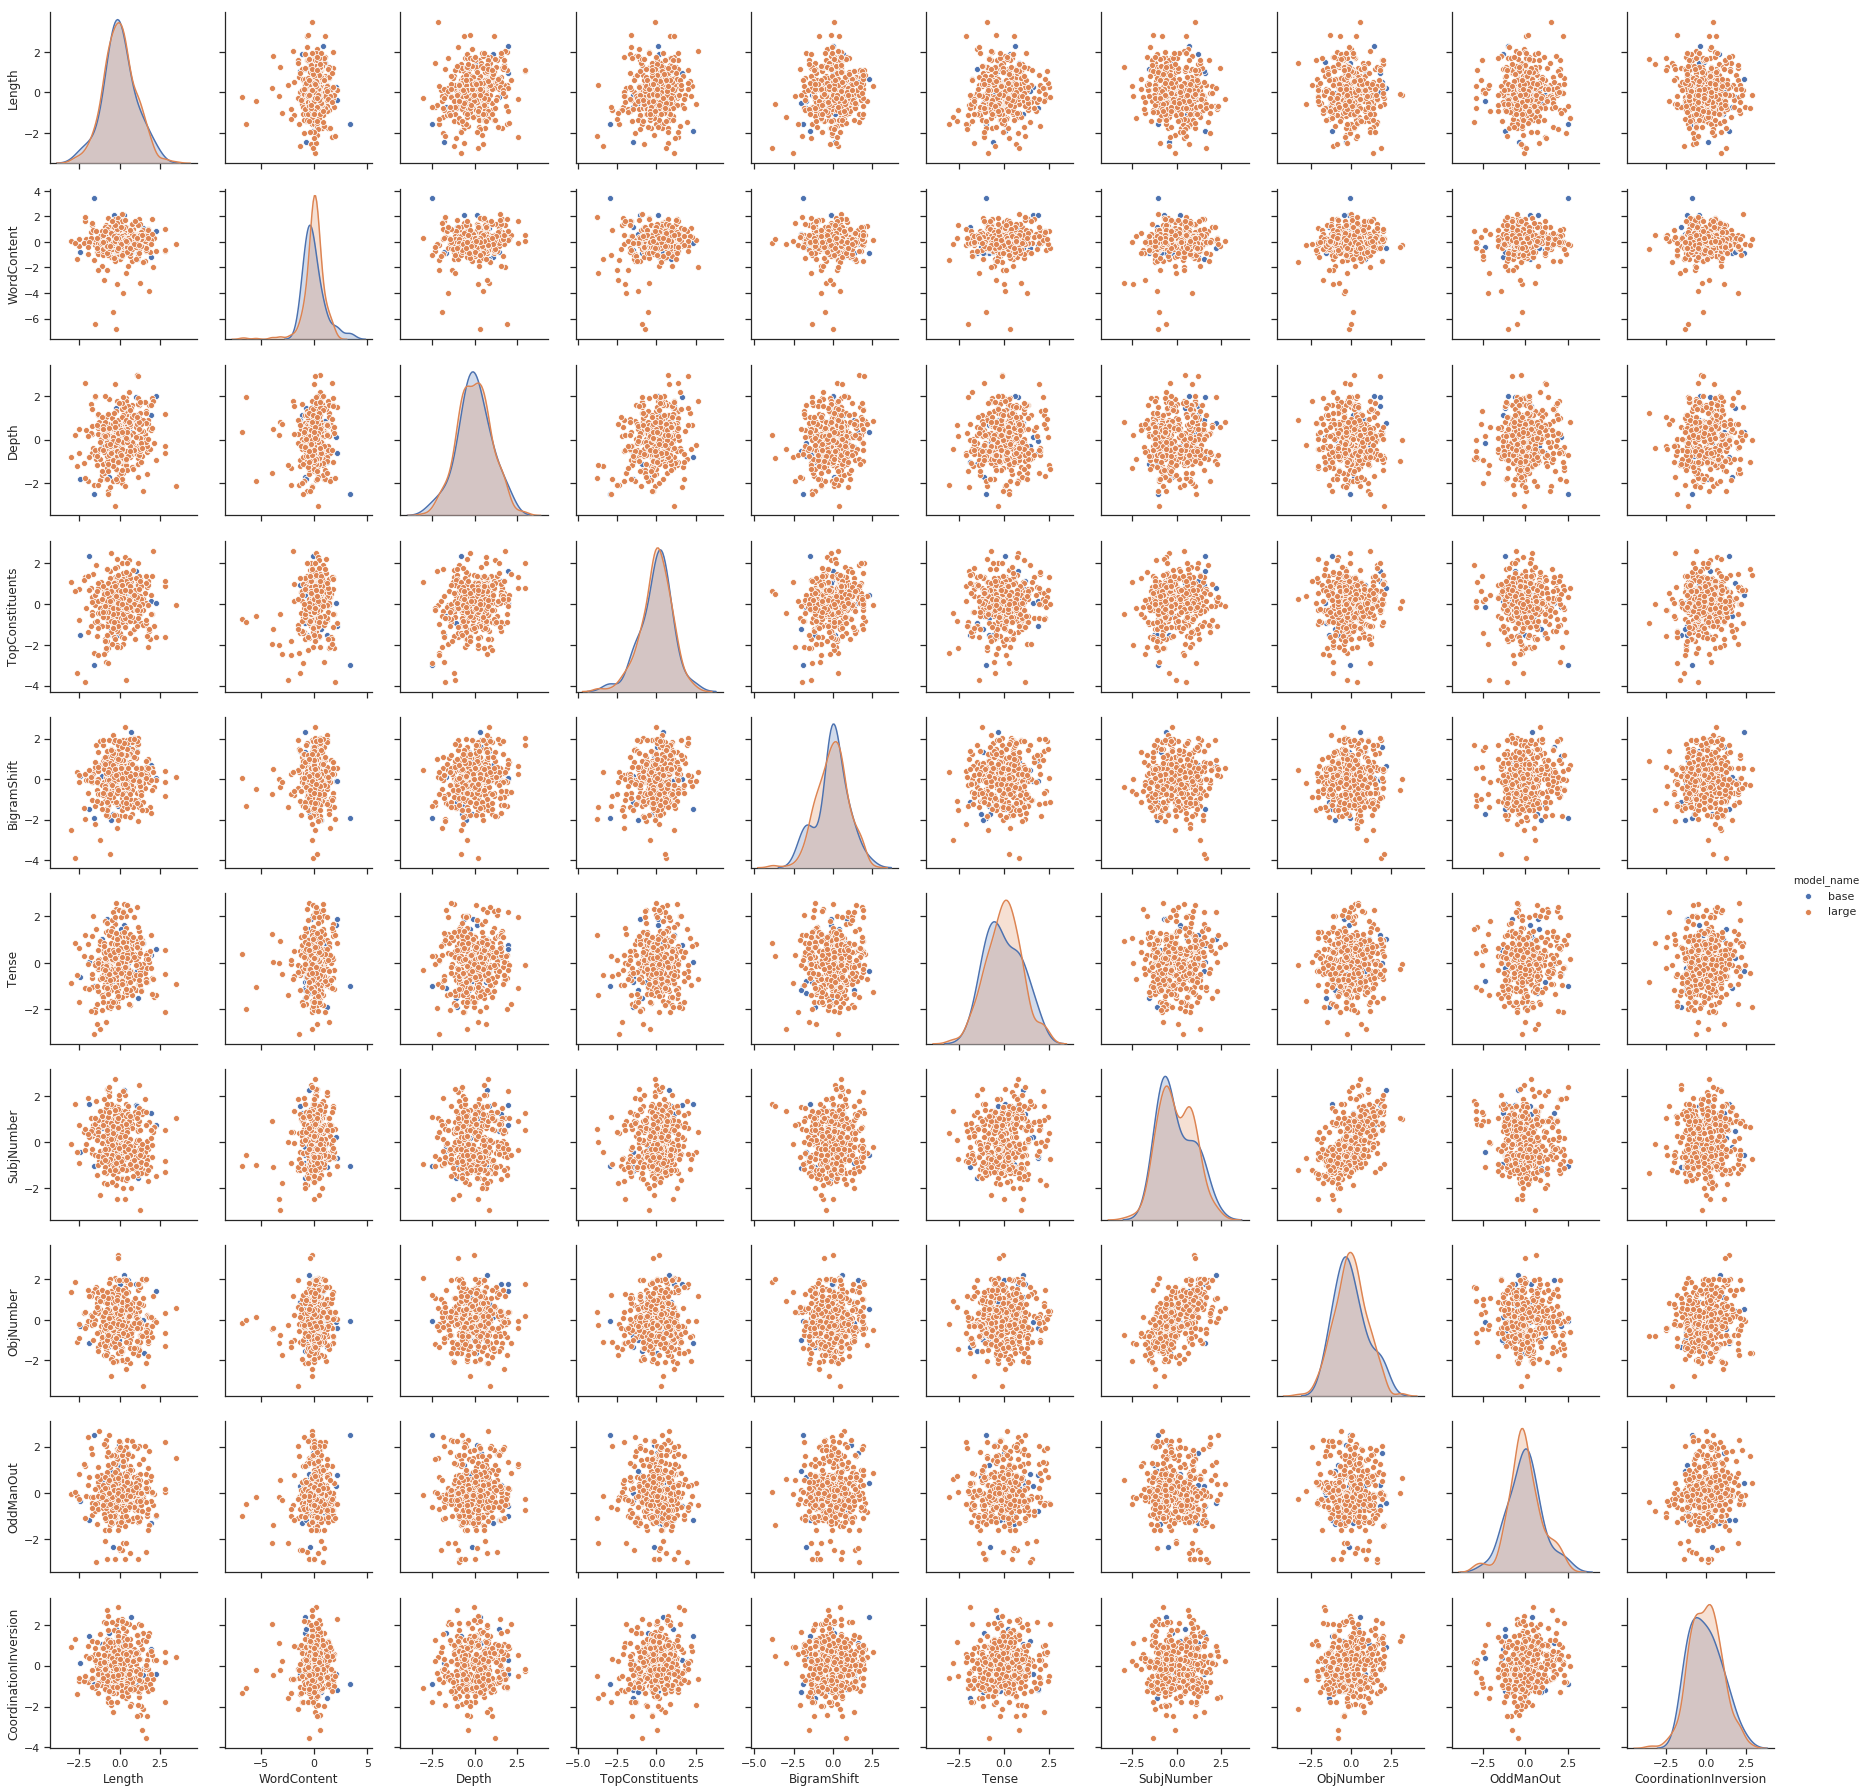

In [13]:
df = get_results(dir_path='./linear_head_wise_results')
df = df.loc[df['model_name'] == 'bert-base-uncased']
df = df.loc[df['head'] >= 0]
df = df.loc[(df['layer'] == 0) | (df['layer'] == 11) | (df['layer'] == 4)]
df = df.pivot_table(index=['layer', 'head'], columns='task', values='acc')

df_avg = df.groupby(level=0).mean()
df = df.sub(df_avg, level=0)

df = df.reset_index() #.drop(columns=['head', 'layer'])
df_task = df[task_order]
df[task_order]=(df_task-df_task.mean())/df_task.std()
df['model_name'] = 'base'
# normalized_df
# display(df)

df2 = get_results(dir_path='./mlp_results')
df2 = df2.loc[df2['model_name'] == 'bert-large-uncased']
df2 = df2.loc[df2['head'] >= 0]
# df2 = df2.loc[(df2['layer'] == 0) | (df2['layer'] == 11) | (df2['layer'] == 4)]
df2 = df2.pivot_table(index=['layer', 'head'], columns='task', values='acc')

df_avg2 = df2.groupby(level=0).mean()
df2 = df2.sub(df_avg2, level=0)

df2 = df2.reset_index() #.drop(columns=['head', 'layer'])
df_task2 = df2[task_order]
df2[task_order]=(df_task2-df_task2.mean())/df_task2.std()
df2['model_name'] = 'large'


# display(df2)

df = df.append(df2)

sns.pairplot(df, hue='model_name', vars=['Length',  'WordContent', 'Depth', 'TopConstituents', 'BigramShift', 'Tense', 'SubjNumber', 'ObjNumber', 'OddManOut', 'CoordinationInversion'])

(384, 10)


No handles with labels found to put in legend.


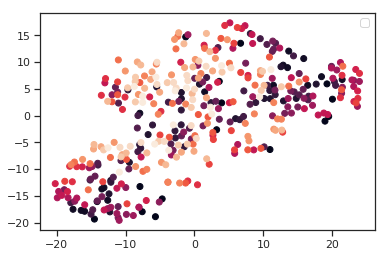

In [14]:
df = get_results(dir_path='./linear_head_wise_results')
df = df.loc[df['model_name'] == 'bert-large-uncased']
df = df.loc[df['head'] >= 0]

df = df.pivot_table(index=['layer', 'head'], columns='task', values='acc')
df_avg = df.groupby(level=0).mean()
df = df.sub(df_avg, level=0)

df = df.reset_index()
layer = df['layer']
df = df.drop(columns=['head', 'layer'])

df_task = df[task_order]
# df[task_order]=(df_task-df_task.mean())/df_task.std()
# display(df)

X = df.values
print(X.shape)
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
X_embedded = TSNE(n_components=2).fit_transform(X)
# X_embedded = PCA(n_components=2).fit_transform(X)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=layer.values)
plt.legend()

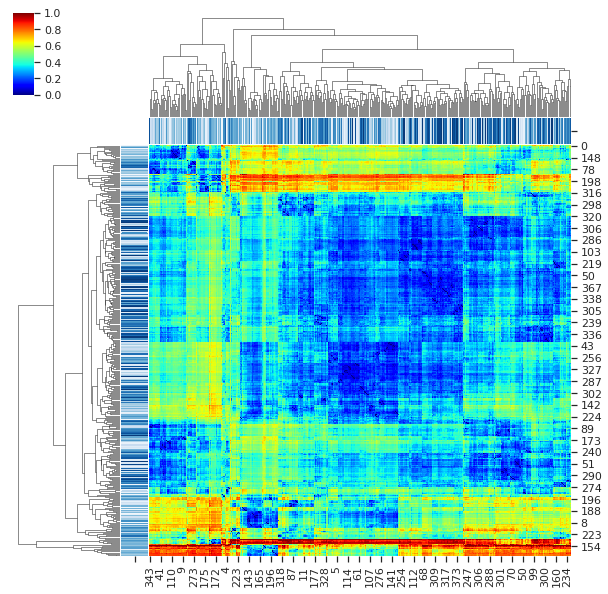

In [15]:
df = get_results(dir_path='./linear_head_wise_results')
df = df.loc[df['model_name'] == 'bert-large-uncased']
df = df.loc[df['head'] >= 0]
df = df.pivot_table(index=['layer', 'head'], columns='task', values='acc')

df_avg = df.groupby(level=0).mean()
df = df.sub(df_avg, level=0)

df_layer = df.index.get_level_values('layer')
# print(df_layer.unique())
lut = dict(zip(df_layer.unique(), sns.color_palette("Blues", len(df_layer.unique()))))
col_colors = pd.Series(df_layer.values).map(lut)
# display(df)
# display(col_colors)

df = df.reset_index().drop(columns=['head', 'layer'])
df = df[task_order]

df = df.T.corr(method=euclidean)
# display(df)
sns.clustermap(df, cmap='jet', metric='euclidean', standard_scale=1, row_cluster=True, col_cluster=True, col_colors=col_colors, row_colors=col_colors)
# sns.heatmap(df, cmap='bwr', center=0)
